### RNN

In [15]:
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define sequence data creation function
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Define MASE calculation function
def calculate_mase(actual, predicted, seasonal_period=1):
    mae_forecast = np.mean(np.abs(actual - predicted))
    mae_naive = np.mean(np.abs(actual[seasonal_period:] - actual[:-seasonal_period]))
    return mae_forecast / mae_naive if mae_naive != 0 else float('inf')

# Define multi-sequence prediction model with 5 layers of LTC
class MultiFeatureRNN(nn.Module):
    def __init__(self, input_size=2, hidden_size=50, output_size=2):
        super(MultiFeatureRNN, self).__init__()
        
        # Define a 5-layer RNN, where each layer receives the output of the previous layer
        self.rnn_layer1 = nn.RNN(input_size, hidden_size, batch_first=True)
        self.rnn_layer2 = nn.RNN(hidden_size, hidden_size, batch_first=True)
        self.rnn_layer3 = nn.RNN(hidden_size, hidden_size, batch_first=True)
        
        # Output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Sequentially pass data through each RNN layer
        out, _ = self.rnn_layer1(x)
        out, _ = self.rnn_layer2(out)
        out, _ = self.rnn_layer3(out)
        
        # Take the output of the last time step
        out = self.fc(out[:, -1, :])  
        return out


# Training function
def train_model(train_loader, val_loader, model, criterion, optimizer, epochs=30):
    best_val_loss = float('inf')
    best_epoch = 0
    best_model_state = None

    start_time = time.time()
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            # Move data to GPU if available
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validate the model
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                # Move data to GPU if available
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                output = model(X_batch)
                loss = criterion(output, y_batch)
                val_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        # Save the best model state
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_epoch = epoch + 1
            best_model_state = model.state_dict()

        print(f'Epoch {epoch+1}/{epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

    end_time = time.time()
    print(f"Total training time: {end_time - start_time:.2f} seconds")
    print(f"Best model achieved at epoch {best_epoch} with validation loss: {best_val_loss:.4f}")
    model.load_state_dict(best_model_state)
    return model,end_time - start_time

# Evaluation function
def evaluate_model(test_loader, model):
    model.eval()
    with torch.no_grad():
        predictions, actuals = [], []
        for X_batch, y_batch in test_loader:
            # Move data to GPU if available
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)
            predictions.extend(output.cpu().numpy())
            actuals.extend(y_batch.cpu().numpy())

    predictions = np.array(predictions)
    actuals = np.array(actuals)

    # Calculate MSE and MASE
    mse_temp = mean_squared_error(actuals[:, 0], predictions[:, 0])
    mse_humidity = mean_squared_error(actuals[:, 1], predictions[:, 1])
    mase_temp = calculate_mase(actuals[:, 0], predictions[:, 0])
    mase_humidity = calculate_mase(actuals[:, 1], predictions[:, 1])

    # Get current GPU memory usage
    if torch.cuda.is_available():
        allocated_memory = torch.cuda.memory_allocated() / (1024 ** 2)  # Convert to MB
        reserved_memory = torch.cuda.memory_reserved() / (1024 ** 2)  # Convert to MB
    else:
        allocated_memory = reserved_memory = None

    print(f"Test set evaluation metrics (on normalized data):")
    print(f"Temperature - MSE: {mse_temp:.4f}, MASE: {mase_temp:.4f}")
    print(f"Humidity - MSE: {mse_humidity:.4f}, MASE: {mase_humidity:.4f}")

    if allocated_memory is not None and reserved_memory is not None:
        print(f"Memory allocated: {allocated_memory:.2f} MB")
        print(f"Memory reserved: {reserved_memory:.2f} MB")

    return predictions, actuals, mse_temp, mse_humidity, mase_temp, mase_humidity, allocated_memory, reserved_memory

# Plot results function
def plot_results(predictions, actuals, title="Comparison of Predicted and Actual Values (Normalized)"):
    results = pd.DataFrame({
        'Predicted Temperature': predictions[:, 0],
        'Actual Temperature': actuals[:, 0],
        'Predicted Humidity': predictions[:, 1],
        'Actual Humidity': actuals[:, 1]
    })
    
    plt.figure(figsize=(12, 6))
    plt.plot(results['Actual Temperature'], label='Actual Temperature', color='blue')
    plt.plot(results['Predicted Temperature'], label='Predicted Temperature', color='red', linestyle='--')
    plt.title(f'Temperature - {title}')
    plt.xlabel('Time Steps')
    plt.ylabel('Normalized Temperature')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(12, 6))
    plt.plot(results['Actual Humidity'], label='Actual Humidity', color='blue')
    plt.plot(results['Predicted Humidity'], label='Predicted Humidity', color='red', linestyle='--')
    plt.title(f'Humidity - {title}')
    plt.xlabel('Time Steps')
    plt.ylabel('Normalized Humidity')
    plt.legend()
    plt.show()




Loading data sets for time series processing

In [16]:

train_data = pd.read_csv('DailyDelhiClimateTrain.csv')
train_data['date'] = pd.to_datetime(train_data['date'])
train_data.set_index('date', inplace=True)
features = train_data[['meantemp', 'humidity']]
scaler = MinMaxScaler(feature_range=(0, 1))
features_scaled = scaler.fit_transform(features)
X, y = create_sequences(features_scaled, seq_length=30)
split_ratio = 0.8
split = int(len(X) * split_ratio)
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]
X_train, y_train = torch.Tensor(X_train).to(device), torch.Tensor(y_train).to(device)
X_val, y_val = torch.Tensor(X_val).to(device), torch.Tensor(y_val).to(device)
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=16, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=16)


test_data = pd.read_csv('DailyDelhiClimateTest.csv')
test_data['date'] = pd.to_datetime(test_data['date'])
test_data.set_index('date', inplace=True)
test_features = test_data[['meantemp', 'humidity']]
test_features_scaled = scaler.transform(test_features)
X_test, y_test = create_sequences(test_features_scaled, seq_length=30)
X_test, y_test = torch.Tensor(X_test).to(device), torch.Tensor(y_test).to(device)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=16)

Training the model and visualizing the results

In [17]:
results_dict = {}
model_name = ['rnn', 'ltc1_tau0.7', 'ltc2_tau1.0', 'ltc3_tau10.0', 'ltc4_tau100.0', 'multi_tau']

Epoch 1/30, Training Loss: 0.1181, Validation Loss: 0.0418
Epoch 2/30, Training Loss: 0.0372, Validation Loss: 0.0355
Epoch 3/30, Training Loss: 0.0290, Validation Loss: 0.0244
Epoch 4/30, Training Loss: 0.0143, Validation Loss: 0.0148
Epoch 5/30, Training Loss: 0.0122, Validation Loss: 0.0142
Epoch 6/30, Training Loss: 0.0120, Validation Loss: 0.0134
Epoch 7/30, Training Loss: 0.0113, Validation Loss: 0.0128
Epoch 8/30, Training Loss: 0.0108, Validation Loss: 0.0127
Epoch 9/30, Training Loss: 0.0103, Validation Loss: 0.0112
Epoch 10/30, Training Loss: 0.0097, Validation Loss: 0.0102
Epoch 11/30, Training Loss: 0.0091, Validation Loss: 0.0098
Epoch 12/30, Training Loss: 0.0090, Validation Loss: 0.0088
Epoch 13/30, Training Loss: 0.0086, Validation Loss: 0.0093
Epoch 14/30, Training Loss: 0.0084, Validation Loss: 0.0083
Epoch 15/30, Training Loss: 0.0085, Validation Loss: 0.0090
Epoch 16/30, Training Loss: 0.0082, Validation Loss: 0.0083
Epoch 17/30, Training Loss: 0.0080, Validation Lo

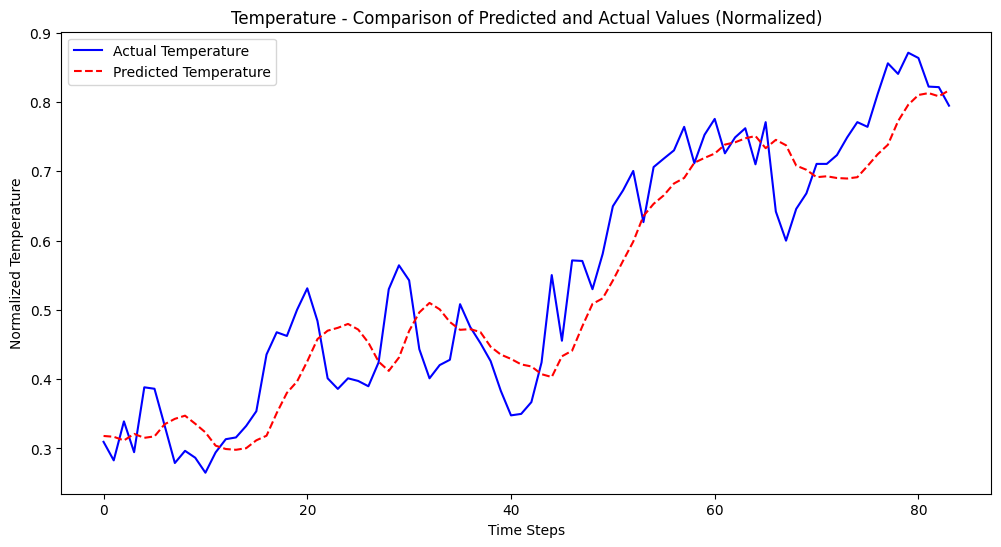

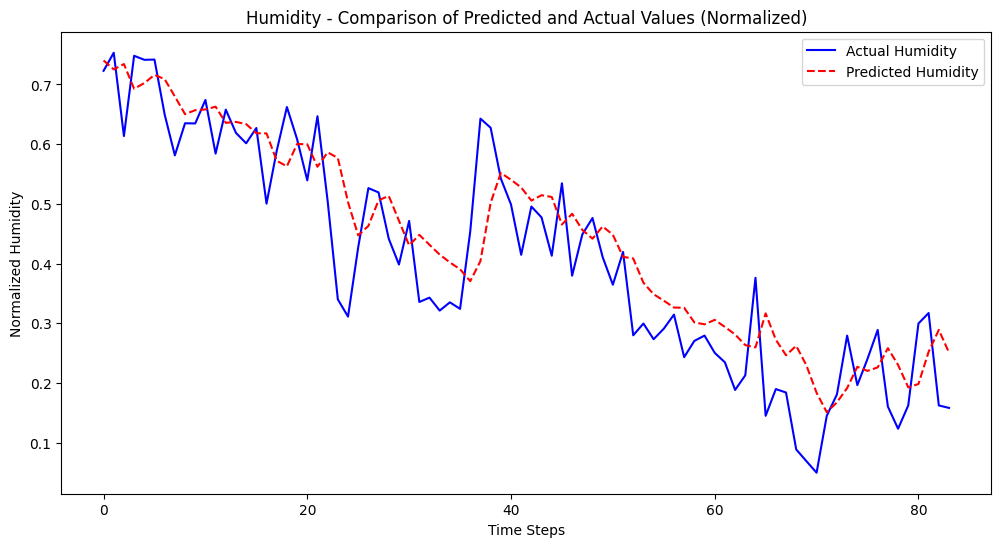

In [18]:

RNNmodel = MultiFeatureRNN(input_size=2, hidden_size=50, output_size=2).to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(RNNmodel.parameters(), lr=0.0001)

RNNmodel,rnn_time = train_model(train_loader, val_loader, RNNmodel, criterion, optimizer)

predictions, actuals, mse_temp, mse_humidity, mase_temp, mase_humidity, allocated_memory, reserved_memory = evaluate_model(test_loader, RNNmodel)

results = {'train_time': rnn_time, 'allocated_memory': allocated_memory, 'reserved_memory': reserved_memory, 
'mse_temp':mse_temp,'mse_humidity':mse_humidity, 'mase_temp':mase_temp, 'mase_humidity':mase_humidity}
results_dict[model_name[0]] = results

plot_results(predictions, actuals)

### LTC

In [19]:
class LTC(nn.Module):
    def __init__(self, input_size, hidden_size, tau=1.0):
        super(LTC, self).__init__()
        self.hidden_size = hidden_size
        self.input_weights = nn.Linear(input_size, hidden_size)
        self.hidden_weights = nn.Linear(hidden_size, hidden_size)
        self.tau = tau

    def forward(self, x, hidden_state):
        input_effect = self.input_weights(x) # x = I(t)
        hidden_effect = self.hidden_weights(hidden_state) # hidden state = X(t)
        combined = input_effect + hidden_effect # combined = A
        
        time_constant_effect = torch.sigmoid(combined) # time_constant_effect = f( x(t), I(t), t, theta )
        dynamic_time_constants = torch.clamp(self.tau / (1 + self.tau * time_constant_effect), min=0.1, max=1.0) # dynamic_time_constants = toll_sys
        
        # Calculate dx/dt
        dx_dt = time_constant_effect * combined - hidden_state / dynamic_time_constants # dx_dt = f( x(t), I(t), t, theta) * A - x(t) / toll_sys
        
        updated_hidden = hidden_state + dx_dt
        return updated_hidden, dx_dt

    def initialize_hidden_state(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size)

# Updated multi-layer LTC model, collecting dx/dt values
class MultiSequenceLTCModel(nn.Module):
    def __init__(self, input_size=2, hidden_size=30, output_size=2, tau1=1.0, tau2=1.0, tau3=1.0):
        super(MultiSequenceLTCModel, self).__init__()
        self.ltc_layer1 = LTC(input_size, hidden_size, tau=tau1)
        self.ltc_layer2 = LTC(hidden_size, hidden_size, tau=tau2)
        self.ltc_layer3 = LTC(hidden_size, hidden_size, tau=tau3)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size, seq_length, _ = x.size()
        hidden_state1 = self.ltc_layer1.initialize_hidden_state(batch_size).to(x.device)
        hidden_state2 = self.ltc_layer2.initialize_hidden_state(batch_size).to(x.device)
        hidden_state3 = self.ltc_layer3.initialize_hidden_state(batch_size).to(x.device)

        dx_dt_values = {'layer1': [], 'layer2': [], 'layer3': []}
        
        for t in range(seq_length):
            hidden_state1, dx_dt1 = self.ltc_layer1(x[:, t, :], hidden_state1)
            hidden_state2, dx_dt2 = self.ltc_layer2(hidden_state1, hidden_state2)
            hidden_state3, dx_dt3 = self.ltc_layer3(hidden_state2, hidden_state3)
            
            # Collect dx/dt values for each layer
            dx_dt_values['layer1'].append(dx_dt1)
            dx_dt_values['layer2'].append(dx_dt2)
            dx_dt_values['layer3'].append(dx_dt3)
        
        out = self.fc(hidden_state3)
        return out, dx_dt_values

In [20]:
def train_LTC_model(train_loader, val_loader, model, criterion, optimizer, epochs=30):
    best_val_loss = float('inf')
    best_epoch = 0
    best_model_state = None
    epoch_dx_dt_history = []  # Records the average dx/dt values for each epoch

    start_time = time.time()
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        epoch_dx_dt_values = {'layer1': [], 'layer2': [], 'layer3': []}

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move data to GPU
            optimizer.zero_grad()
            output, dx_dt_values = model(X_batch)  # Assuming the model returns output and dx_dt_values
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # Collect the average dx/dt values for each batch
            for layer, values in dx_dt_values.items():
                epoch_dx_dt_values[layer].append(torch.stack(values).mean().item())
        
        # Calculate and record the average dx/dt values for each layer across the entire epoch
        avg_dx_dt = {layer: sum(values) / len(values) for layer, values in epoch_dx_dt_values.items()}
        
        # Calculate the average of the total dx/dt values across the three layers
        total_avg_dx_dt = sum(avg_dx_dt.values()) / len(avg_dx_dt)
        
        epoch_dx_dt_history.append({'total_avg_dx_dt': total_avg_dx_dt})

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)  
                output, _ = model(X_batch)
                loss = criterion(output, y_batch)
                val_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_epoch = epoch + 1
            best_model_state = model.state_dict()

        print(f'Epoch {epoch+1}/{epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
        print(f'Average dx/dt values for each layer: {avg_dx_dt}, Average dx/dt value across three layers: {total_avg_dx_dt:.4f}')

    end_time = time.time()
    print(f"Total training time: {end_time - start_time:.2f} seconds")
    print(f"Best model at epoch {best_epoch}, Validation Loss: {best_val_loss:.4f}")
    model.load_state_dict(best_model_state)
    
    return model, end_time - start_time, epoch_dx_dt_history



In [21]:
import plotly.graph_objs as go
def evaluate_LTC_model(test_loader, model):
    model.eval()
    with torch.no_grad():
        predictions, actuals = [], []
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)  
            output, _ = model(X_batch)
            predictions.extend(output.cpu().numpy()) 
            actuals.extend(y_batch.cpu().numpy())  

    predictions = np.array(predictions)
    actuals = np.array(actuals)

    # Calculate MSE and MASE
    mse_temp = mean_squared_error(actuals[:, 0], predictions[:, 0])
    mse_humidity = mean_squared_error(actuals[:, 1], predictions[:, 1])
    mase_temp = calculate_mase(actuals[:, 0], predictions[:, 0])
    mase_humidity = calculate_mase(actuals[:, 1], predictions[:, 1])

    # Get the current GPU memory usage
    if torch.cuda.is_available():
        allocated_memory = torch.cuda.memory_allocated() / (1024 ** 2)  
        reserved_memory = torch.cuda.memory_reserved() / (1024 ** 2)  
    else:
        allocated_memory = reserved_memory = None

    print("Test set evaluation metrics (on normalized data):")
    print(f"Temperature - MSE: {mse_temp:.4f}, MASE: {mase_temp:.4f}")
    print(f"Humidity - MSE: {mse_humidity:.4f}, MASE: {mase_humidity:.4f}")

    if allocated_memory is not None and reserved_memory is not None:
        print(f"Memory allocated: {allocated_memory:.2f} MB")
        print(f"Memory reserved: {reserved_memory:.2f} MB")

    return predictions, actuals, mse_temp, mse_humidity, mase_temp, mase_humidity, allocated_memory, reserved_memory

# Visualization function to show the trend of dx/dt for each layer
def plot_dx_dt_history(epoch_dx_dt_history):

    epochs = list(range(1, len(epoch_dx_dt_history) + 1))
    
    # Get the names of the layers (e.g., 'layer1', 'layer2', 'layer3')
    layer_names = epoch_dx_dt_history[0].keys()
    
    fig = go.Figure()

    # Add a line for each layer to show the trend of dx/dt
    for layer in layer_names:
        # Collect the average dx/dt values for the current layer in each epoch
        layer_dx_dt_values = [epoch_data[layer] for epoch_data in epoch_dx_dt_history]
        
        fig.add_trace(go.Scatter(
            x=epochs, 
            y=layer_dx_dt_values, 
            mode='lines+markers',
            name=f'{layer} dx/dt',
            line=dict(width=2),
            marker=dict(size=6)
        ))

    fig.update_layout(
        title="Trend of dx/dt for Each Layer Across Epochs",
        xaxis_title="Epoch",
        yaxis_title="dx/dt Average Value",
        legend_title="Layer Name"
    )

    fig.show()

tau = 0.7

Epoch 1/30, Training Loss: 2755.4556, Validation Loss: 1016.8037
Average dx/dt values for each layer: {'layer1': 0.20150715112686157, 'layer2': 0.5368951054082977, 'layer3': 0.4277739452405108}, Average dx/dt value across three layers: 0.3887
Epoch 2/30, Training Loss: 667.8959, Validation Loss: 743.1980
Average dx/dt values for each layer: {'layer1': 0.20036850435038409, 'layer2': 0.5688284209205045, 'layer3': 0.2876095560689767}, Average dx/dt value across three layers: 0.3523
Epoch 3/30, Training Loss: 405.2745, Validation Loss: 297.9201
Average dx/dt values for each layer: {'layer1': 0.1921561983310514, 'layer2': 0.5261259861290455, 'layer3': 0.2981239352375269}, Average dx/dt value across three layers: 0.3388
Epoch 4/30, Training Loss: 323.7710, Validation Loss: 666.2577
Average dx/dt values for each layer: {'layer1': 0.19005370077987513, 'layer2': 0.5255064728359381, 'layer3': 0.30198919648925465}, Average dx/dt value across three layers: 0.3392
Epoch 5/30, Training Loss: 368.615

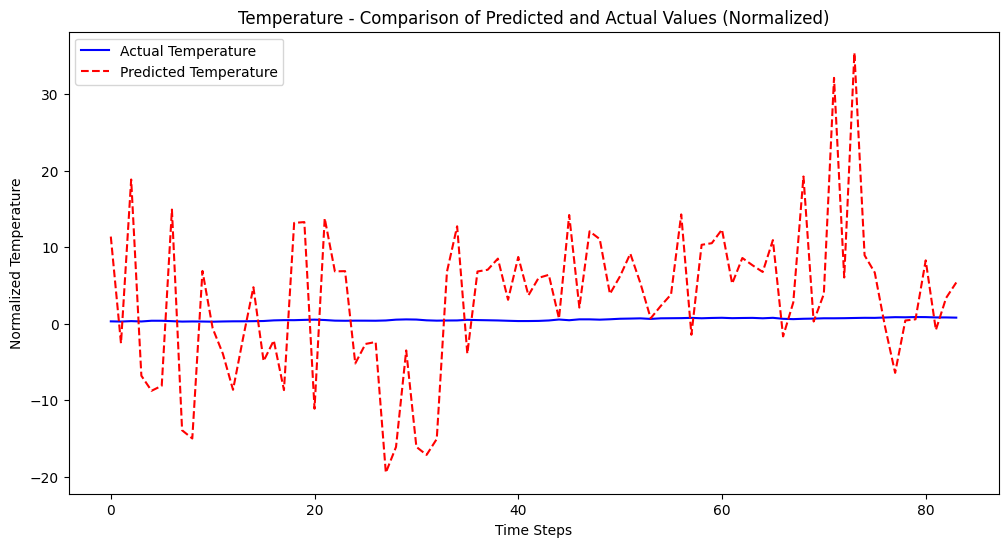

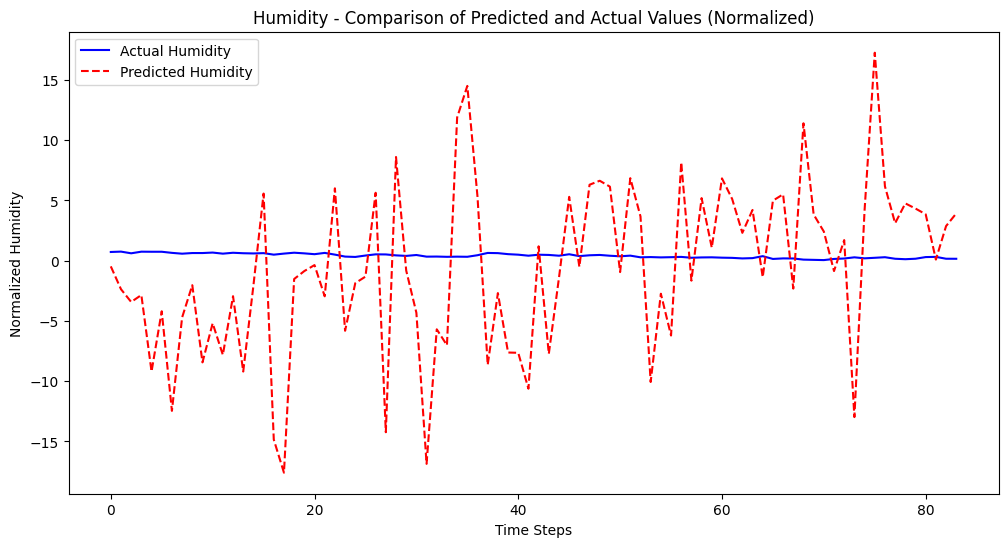

In [22]:
ltc_1 = MultiSequenceLTCModel(input_size=2, hidden_size=50, output_size=2,tau1=0.7, tau2=0.7, tau3=0.7).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(ltc_1.parameters(), lr=0.0001)

ltc_1,ltc1_time,epoch_dx_dt_history = train_LTC_model(train_loader, val_loader, ltc_1, criterion, optimizer)


predictions, actuals, mse_temp, mse_humidity, mase_temp, mase_humidity, allocated_memory, reserved_memory = evaluate_LTC_model(test_loader, ltc_1)
results = {'train_time': ltc1_time, 'allocated_memory': allocated_memory, 'reserved_memory': reserved_memory, 'epoch_dx_dt_history':epoch_dx_dt_history,
 'mse_temp':mse_temp,'mse_humidity':mse_humidity, 'mase_temp':mase_temp, 'mase_humidity':mase_humidity}
results_dict[model_name[1]] = results

plot_results(predictions, actuals)

plot_dx_dt_history(epoch_dx_dt_history)

tau = 1

Epoch 1/30, Training Loss: 0.2558, Validation Loss: 0.0823
Average dx/dt values for each layer: {'layer1': 0.0009058946387894037, 'layer2': 0.0006517037606196633, 'layer3': 0.00012396019210175128}, Average dx/dt value across three layers: 0.0006
Epoch 2/30, Training Loss: 0.0461, Validation Loss: 0.0347
Average dx/dt values for each layer: {'layer1': 0.0011356892516940003, 'layer2': 0.0027118350909505454, 'layer3': 0.0013238214798750253}, Average dx/dt value across three layers: 0.0017
Epoch 3/30, Training Loss: 0.0245, Validation Loss: 0.0156
Average dx/dt values for each layer: {'layer1': 0.0017480911628808826, 'layer2': 0.003950093032067848, 'layer3': 0.001588283118002841}, Average dx/dt value across three layers: 0.0024
Epoch 4/30, Training Loss: 0.0147, Validation Loss: 0.0138
Average dx/dt values for each layer: {'layer1': 0.002666686661541462, 'layer2': 0.004877751324481021, 'layer3': 0.002041984035814595}, Average dx/dt value across three layers: 0.0032
Epoch 5/30, Training Los

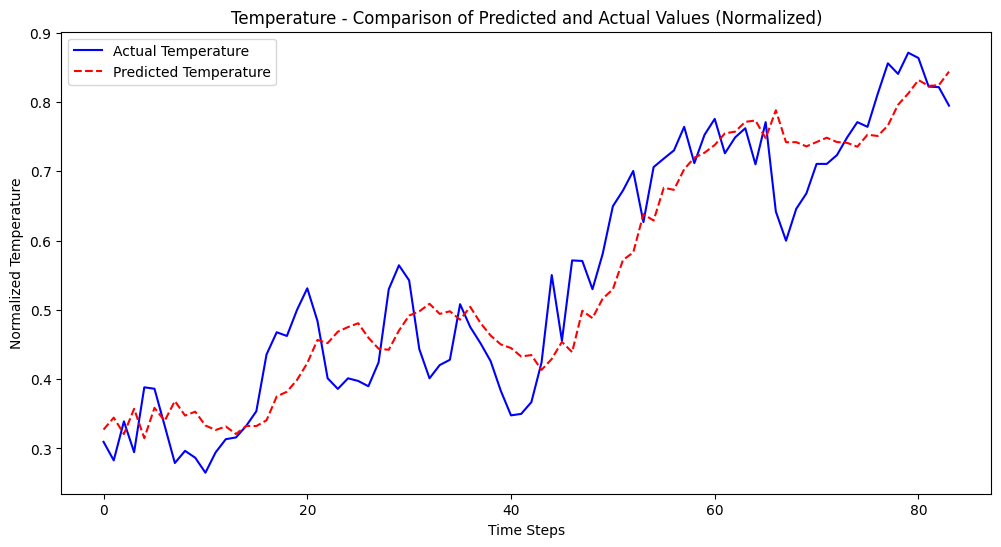

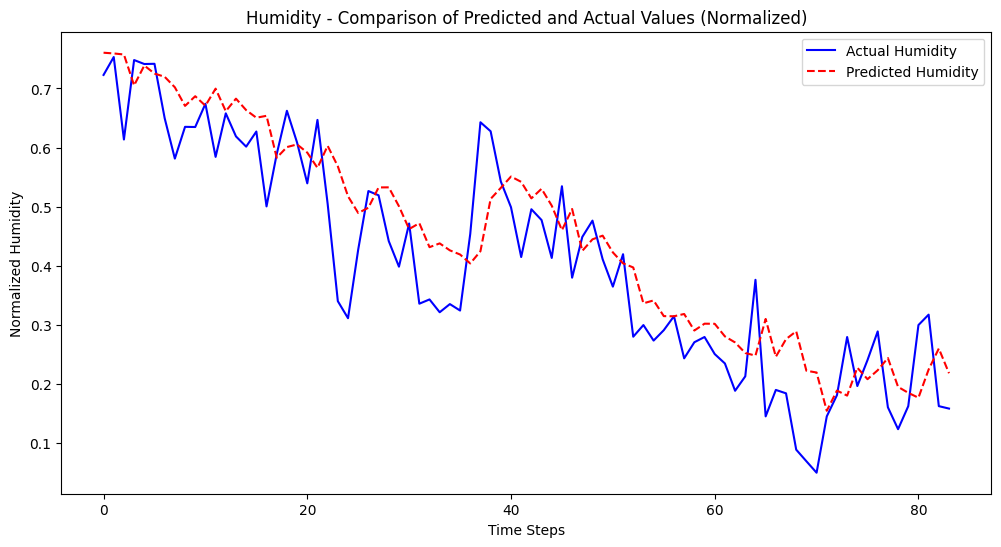

In [23]:
ltc_2 = MultiSequenceLTCModel(input_size=2, hidden_size=50, output_size=2,tau1=1.0, tau2=1.0, tau3=1.0).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(ltc_2.parameters(), lr=0.0001)

ltc_2,ltc2_time,epoch_dx_dt_history = train_LTC_model(train_loader, val_loader, ltc_2, criterion, optimizer)


predictions, actuals, mse_temp, mse_humidity, mase_temp, mase_humidity, allocated_memory, reserved_memory = evaluate_LTC_model(test_loader, ltc_2)
results = {'train_time': ltc2_time, 'allocated_memory': allocated_memory, 'reserved_memory': reserved_memory, 'epoch_dx_dt_history':epoch_dx_dt_history,
 'mse_temp':mse_temp,'mse_humidity':mse_humidity, 'mase_temp':mase_temp, 'mase_humidity':mase_humidity}
results_dict[model_name[2]] = results

plot_results(predictions, actuals)

plot_dx_dt_history(epoch_dx_dt_history)

tau=10.0

Epoch 1/30, Training Loss: 0.1858, Validation Loss: 0.0793
Average dx/dt values for each layer: {'layer1': 0.005201238906010985, 'layer2': 0.00018449056790201566, 'layer3': 0.001046496586544284}, Average dx/dt value across three layers: 0.0021
Epoch 2/30, Training Loss: 0.0432, Validation Loss: 0.0404
Average dx/dt values for each layer: {'layer1': 0.0076462363487937385, 'layer2': 0.002673571686803674, 'layer3': 0.002970308555328908}, Average dx/dt value across three layers: 0.0044
Epoch 3/30, Training Loss: 0.0355, Validation Loss: 0.0342
Average dx/dt values for each layer: {'layer1': 0.007894715546475103, 'layer2': 0.003020431885185341, 'layer3': 0.0031537440922369975}, Average dx/dt value across three layers: 0.0047
Epoch 4/30, Training Loss: 0.0285, Validation Loss: 0.0237
Average dx/dt values for each layer: {'layer1': 0.008307881316997938, 'layer2': 0.0033914568711123946, 'layer3': 0.0033207053460905123}, Average dx/dt value across three layers: 0.0050
Epoch 5/30, Training Loss:

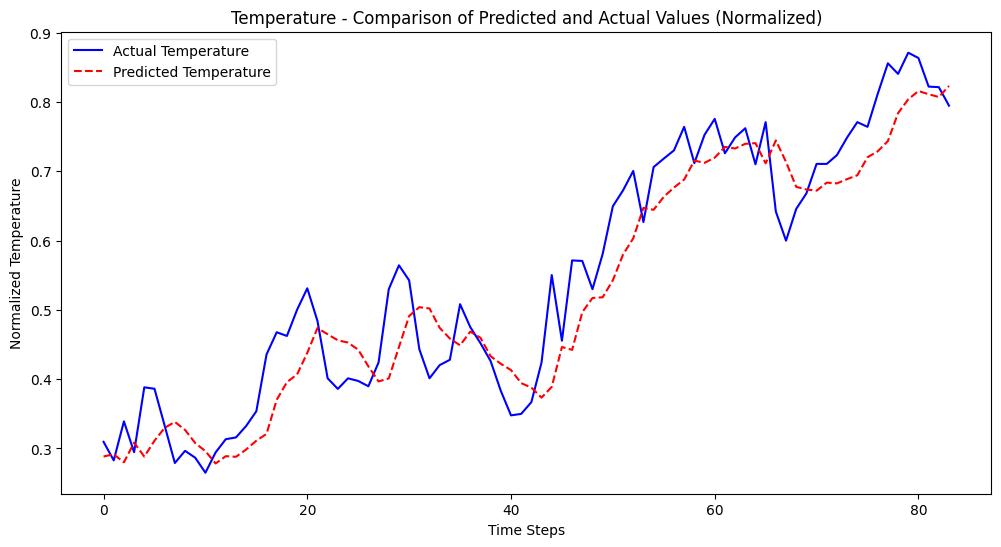

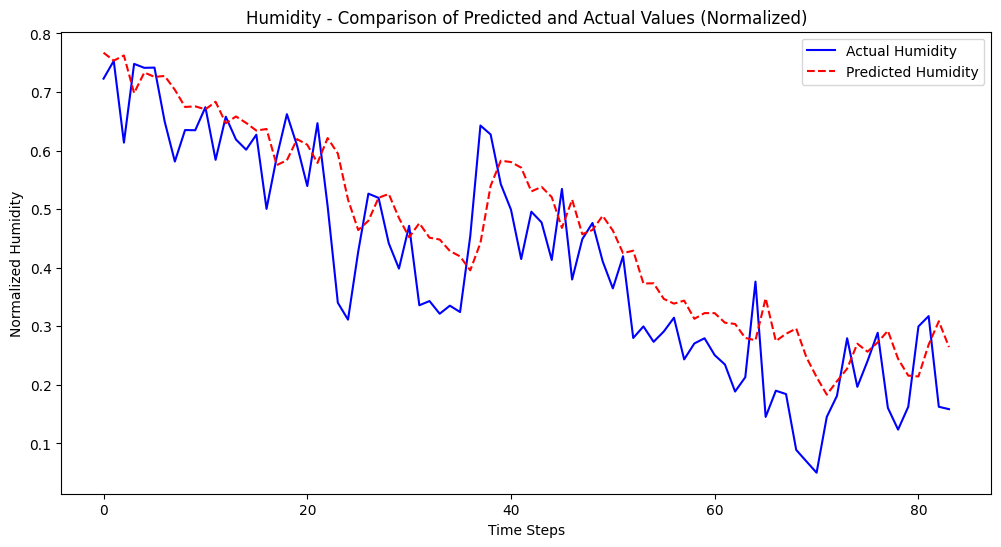

In [24]:
ltc_3 = MultiSequenceLTCModel(input_size=2, hidden_size=50, output_size=2,tau1=10.0, tau2=10.0, tau3=10.0).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(ltc_3.parameters(), lr=0.0001)

ltc_3,ltc3_time,epoch_dx_dt_history = train_LTC_model(train_loader, val_loader, ltc_3, criterion, optimizer)


predictions, actuals, mse_temp, mse_humidity, mase_temp, mase_humidity, allocated_memory, reserved_memory = evaluate_LTC_model(test_loader, ltc_3)
results = {'train_time': ltc3_time, 'allocated_memory': allocated_memory, 'reserved_memory': reserved_memory, 'epoch_dx_dt_history':epoch_dx_dt_history,
 'mse_temp':mse_temp,'mse_humidity':mse_humidity, 'mase_temp':mase_temp, 'mase_humidity':mase_humidity}
results_dict[model_name[3]] = results

plot_results(predictions, actuals)

plot_dx_dt_history(epoch_dx_dt_history)

tau=100.0

Epoch 1/30, Training Loss: 0.3220, Validation Loss: 0.2533
Average dx/dt values for each layer: {'layer1': 0.0031380530013444107, 'layer2': -0.0003505634522298351, 'layer3': -0.0005889848891658605}, Average dx/dt value across three layers: 0.0007
Epoch 2/30, Training Loss: 0.0957, Validation Loss: 0.0344
Average dx/dt values for each layer: {'layer1': 0.004361929391355564, 'layer2': 0.0004400618060726755, 'layer3': -9.558667226075259e-05}, Average dx/dt value across three layers: 0.0016
Epoch 3/30, Training Loss: 0.0341, Validation Loss: 0.0323
Average dx/dt values for each layer: {'layer1': 0.005059052310470078, 'layer2': 0.0011856672297451748, 'layer3': 0.00042961164015448757}, Average dx/dt value across three layers: 0.0022
Epoch 4/30, Training Loss: 0.0314, Validation Loss: 0.0283
Average dx/dt values for each layer: {'layer1': 0.005172570507662992, 'layer2': 0.0013092188487967683, 'layer3': 0.00047991120623515197}, Average dx/dt value across three layers: 0.0023
Epoch 5/30, Traini

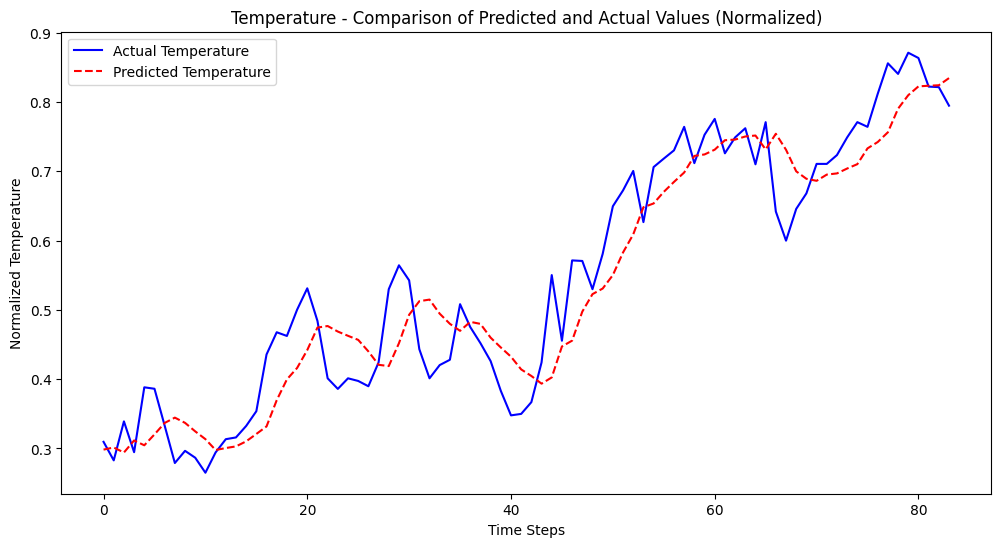

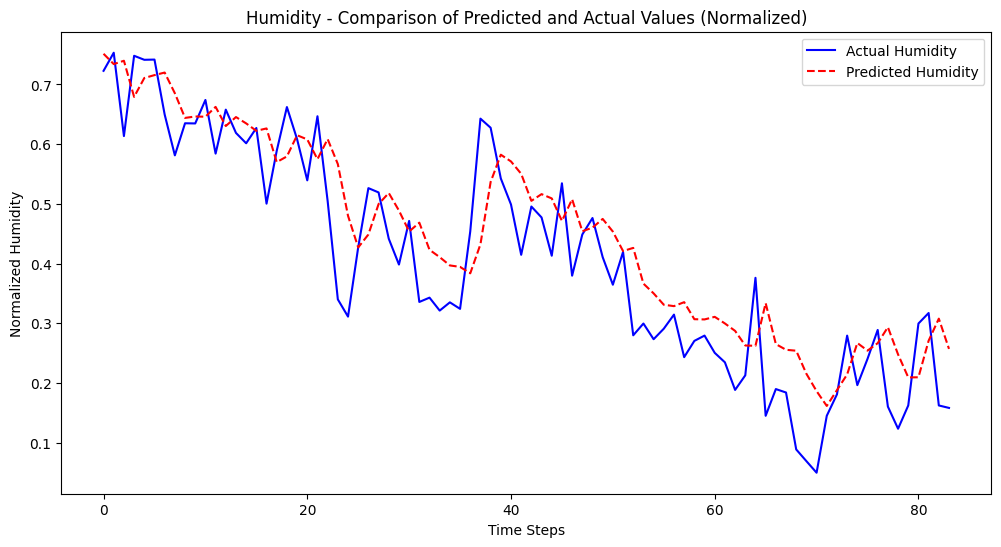

In [25]:

ltc_4 = MultiSequenceLTCModel(input_size=2, hidden_size=50, output_size=2,tau1=100.0, tau2=100.0, tau3=100.0).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(ltc_4.parameters(), lr=0.0001)

ltc_4,ltc4_time,epoch_dx_dt_history = train_LTC_model(train_loader, val_loader, ltc_4, criterion, optimizer)


predictions, actuals, mse_temp, mse_humidity, mase_temp, mase_humidity, allocated_memory, reserved_memory = evaluate_LTC_model(test_loader, ltc_4)
results = {'train_time': ltc4_time, 'allocated_memory': allocated_memory, 'reserved_memory': reserved_memory, 'epoch_dx_dt_history':epoch_dx_dt_history,
 'mse_temp':mse_temp,'mse_humidity':mse_humidity, 'mase_temp':mase_temp, 'mase_humidity':mase_humidity}
results_dict[model_name[4]] = results

plot_results(predictions, actuals)

plot_dx_dt_history(epoch_dx_dt_history)

multi_tau:tau1=1.0, tau2=10.0, tau3=100.0

Epoch 1/30, Training Loss: 0.1894, Validation Loss: 0.0582
Average dx/dt values for each layer: {'layer1': 0.0028676746490721903, 'layer2': 0.0002678138133155193, 'layer3': 0.0003333327607480088}, Average dx/dt value across three layers: 0.0012
Epoch 2/30, Training Loss: 0.0372, Validation Loss: 0.0294
Average dx/dt values for each layer: {'layer1': 0.006548786283625911, 'layer2': 0.0030035714007681236, 'layer3': 0.002537220452925087}, Average dx/dt value across three layers: 0.0040
Epoch 3/30, Training Loss: 0.0297, Validation Loss: 0.0234
Average dx/dt values for each layer: {'layer1': 0.007485671137045655, 'layer2': 0.0033591743235269356, 'layer3': 0.002708915601639698}, Average dx/dt value across three layers: 0.0045
Epoch 4/30, Training Loss: 0.0183, Validation Loss: 0.0131
Average dx/dt values for each layer: {'layer1': 0.010832549926514426, 'layer2': 0.004917268508708932, 'layer3': 0.003196748762598468}, Average dx/dt value across three layers: 0.0063
Epoch 5/30, Training Loss: 

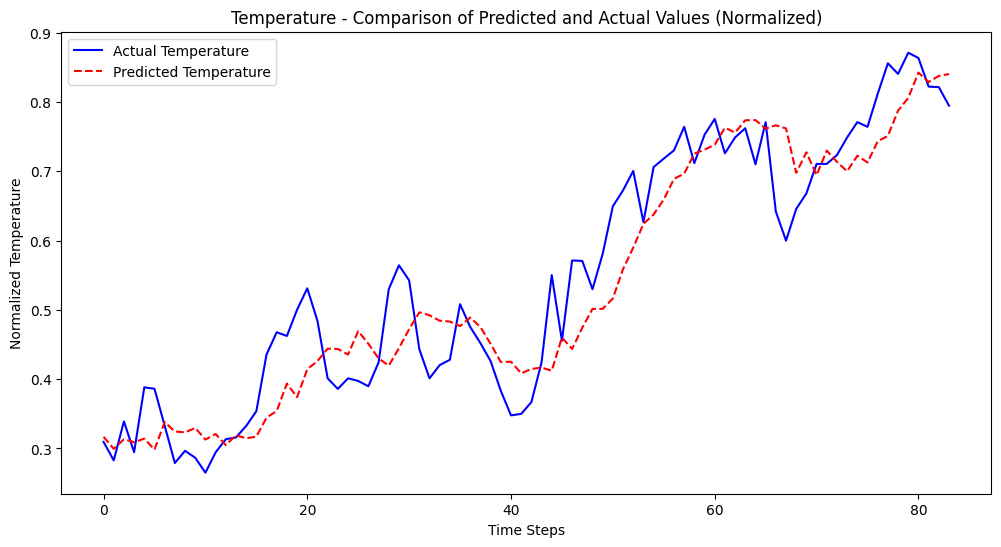

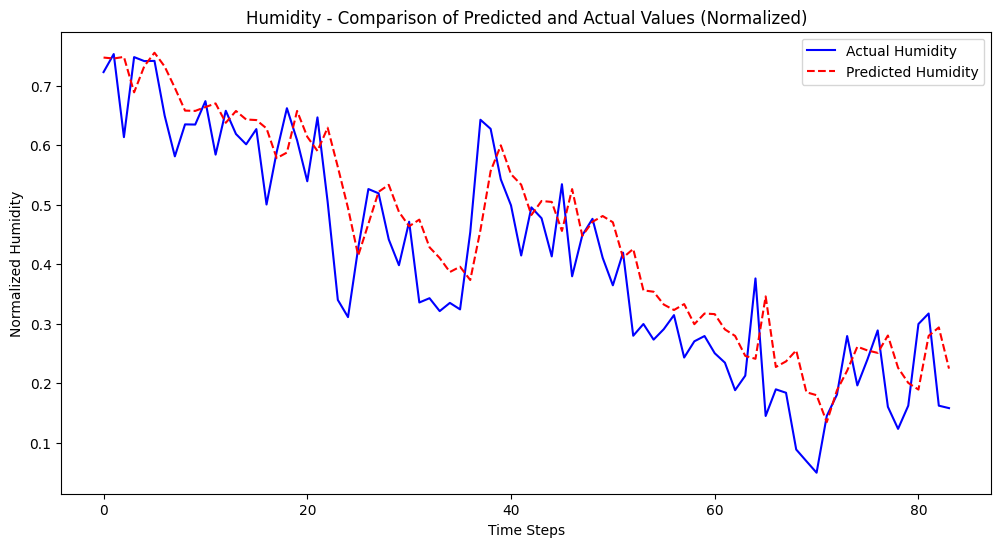

In [26]:

ltc_5 = MultiSequenceLTCModel(input_size=2, hidden_size=50, output_size=2,tau1=1.0, tau2=10.0, tau3=100.0).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(ltc_5.parameters(), lr=0.0001)

ltc_5,ltc5_time,epoch_dx_dt_history = train_LTC_model(train_loader, val_loader, ltc_5, criterion, optimizer)

predictions, actuals, mse_temp, mse_humidity, mase_temp, mase_humidity, allocated_memory, reserved_memory = evaluate_LTC_model(test_loader, ltc_5)
results = {'train_time': ltc5_time, 'allocated_memory': allocated_memory, 'reserved_memory': reserved_memory, 'epoch_dx_dt_history':epoch_dx_dt_history,
 'mse_temp':mse_temp,'mse_humidity':mse_humidity, 'mase_temp':mase_temp, 'mase_humidity':mase_humidity}
results_dict[model_name[5]] = results

plot_results(predictions, actuals)

plot_dx_dt_history(epoch_dx_dt_history)

In [27]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

def visualize_model_results(results_dict):

    model_names = list(results_dict.keys())
    
    metrics_to_visualize = ['train_time', 'allocated_memory', 'reserved_memory', 'epoch_dx_dt_history',
                            'mse_temp', 'mse_humidity', 'mase_temp', 'mase_humidity']
    
    # Create subplots with 2 columns and one metric per subplot
    num_metrics = len(metrics_to_visualize)
    fig = make_subplots(rows=(num_metrics + 1) // 2, cols=2, 
                        subplot_titles=[metric.replace('_', ' ').title() for metric in metrics_to_visualize])

    for i, metric in enumerate(metrics_to_visualize):
        # Determine the current subplot position
        row = i // 2 + 1
        col = i % 2 + 1

        for model in model_names:
            metrics = results_dict[model]

            if metric in ['train_time', 'allocated_memory', 'reserved_memory', 'mse_temp', 'mse_humidity', 'mase_temp', 'mase_humidity']:
                value = metrics.get(metric)
                if value is not None:

                    fig.add_trace(go.Bar(
                        x=[model], 
                        y=[value], 
                        name=metric.replace('_', ' ').title(),
                        text=[f"{value:.4f}" if metric != 'epoch_dx_dt_history' else ""],  
                        texttemplate='%{text}',
                        textposition='outside'
                    ), row=row, col=col)

            elif metric == 'epoch_dx_dt_history' and model != 'rnn': 
                dx_dt_values = [entry['total_avg_dx_dt'] for entry in metrics['epoch_dx_dt_history']]
                epochs = list(range(1, len(dx_dt_values) + 1))  

                fig.add_trace(go.Scatter(
                    x=epochs,
                    y=dx_dt_values, 
                    mode='lines+markers',
                    name=model,
                    text=[f"{val:.6f}" for val in dx_dt_values],
                    textposition='top center'
                ), row=row, col=col)

        fig.update_xaxes(title_text="Models" if metric != 'epoch_dx_dt_history' else "Epochs", row=row, col=col)
        fig.update_yaxes(title_text=metric.replace('_', ' ').title(), row=row, col=col)

    fig.update_layout(
        title="Model Performance Metrics",
        legend_title="Metrics",
        height=1600,  
        showlegend=True  
    )

    fig.show()

# Usage example
# visualize_model_results(results_dict)


In [28]:

visualize_model_results(results_dict)
